# Tasks

## 1. Given the final estimation of the trend $\widehat{T}_t$ and sesonal $\widehat{S}_t$ components in Section 2, plot the observed and fitted values produced by the sequential decomposition approach.  

Let's begin our script by importing necessary libraries:

In [1]:
# Import some external libraries
import pandas as pd                # For data manipulation
import matplotlib.pyplot as plt    # For visualization
import numpy as np                 # For linear algebra
from sklearn.linear_model import LinearRegression 

Then read the data file into a `DataFrame` object and use the `Month` column as the index of the `DataFrame` and plot the time seres data

In [2]:
# Read data from a csv file
data = pd.read_csv('AirPassengers.csv')       
data['Month'] = pd.to_datetime(data['Month']) # Convert the data in the Month column to datetime
data.set_index('Month', inplace=True)         # Indexing the DataFrame by the Month column

Then we repeat the process of estimating the initial trend, seasonality and final trend as shown in the tutorial

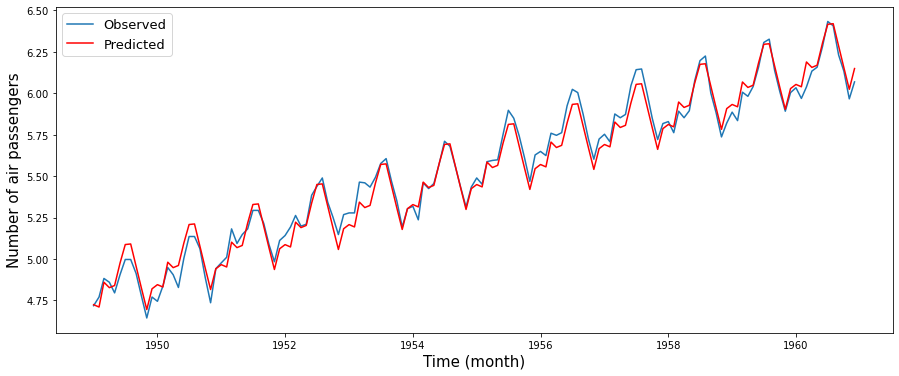

In [3]:
# Extract Passengers column
ts = data['Passengers']

# Apply log transformation to all observations
ts_log = np.log(ts) 

# Apply CMA-M with M=12 to initially estimate the trend
# Shift the new series to equalize (symmetrize) the number of missing values on both sides
Trend_init = ts_log.rolling(12,center=True).mean().rolling(2,center=True).mean().shift(-1)

# Subtract the initial trend from the original series to obtaibed the de-trend series
ts_res = ts_log - Trend_init

# Replace missing values in the ts_res by zeros
ts_res_zero = np.nan_to_num(ts_res)

# Reshape the de-trended series to a table. 
# A column contains data in a particular month of 12 years.
# For example, column 1 contains number of passengers in January of 12 years.
monthly_S = np.reshape(ts_res_zero, (12,12))

# Calculate column averages (Average number of passengers in 12 months of 12 years)
monthly_avg = np.mean(monthly_S[1:11,:], axis=0)

# Normalize the seasonal index
seasonal_idx = monthly_avg.mean()
seasonal_idx_normalized = monthly_avg - seasonal_idx

# Replicate the normalized seasonal index array 12 times 
# to obtain the final estimation of the seasonal component
seasonal = np.tile(seasonal_idx_normalized, 12)

# Subtract the seasonal average from the original data 
# to obtain the seasonal adjusted data
seasonally_adjusted = ts_log - seasonal

# Now estimate the final trend
# Prepare training data
X = np.linspace(1, len(seasonally_adjusted), len(seasonally_adjusted)) # Create time indexes from 1 to T as the input
X = np.reshape(X, (len(seasonally_adjusted), 1))                       # Transform X to 2D array (matrix)
y = seasonally_adjusted.values    

# Create a LinearRegression object
lm = LinearRegression()   

# Train the linear regression model on training data (X,y)
lm.fit(X, y)

# Obtain estimation for the trend using the trained linear model
X_fitting = np.reshape(np.arange(len(seasonally_adjusted)), (len(seasonally_adjusted),1))
trend_linear = lm.predict(X_fitting)

# Get the fitted values for y = Trend + seasonal
y_fitted = trend_linear + seasonal

# Visually compare the observed and fitted values
plt.figure(figsize=(15,6))
plt.plot(ts_log.index,ts_log, label='Observed')
plt.plot(ts_log.index,y_fitted, '-r', label='Predicted')
plt.xlabel('Time (month)',fontsize=15)
plt.ylabel('Number of air passengers',fontsize=15)
plt.legend(fontsize=13)
plt.show()

## 2. Given the estimation of the trend $\widehat{T}_t$ and sesonal $\widehat{S}_t$ components in Step 2 and Step 3, estimate the cycle component $\widehat{C}_t$. 

Once the trend and seasonal components have be estimated, we can use the additive function of the decomposition method to estimate the cycle component

In [4]:
# Get the cycle-remainder component estimates
cycle_remainder = ts_log - (seasonal+trend_linear)

# Smooth the cycle-remainder component to obtain the cycle estimation
cycle = cycle_remainder.rolling(12,center=True).mean().rolling(2,center=True).mean().shift(-1)

## 3. Given the estimation of the trend, sesonal and cycle components, estimate the remainder component. 

Given the trend, seasonal and cycle estimates, we can easily obtain the estimation for the remainder component

In [5]:
remainder = ts_log - (seasonal+trend_linear+cycle)

Then we can plot all component togethers

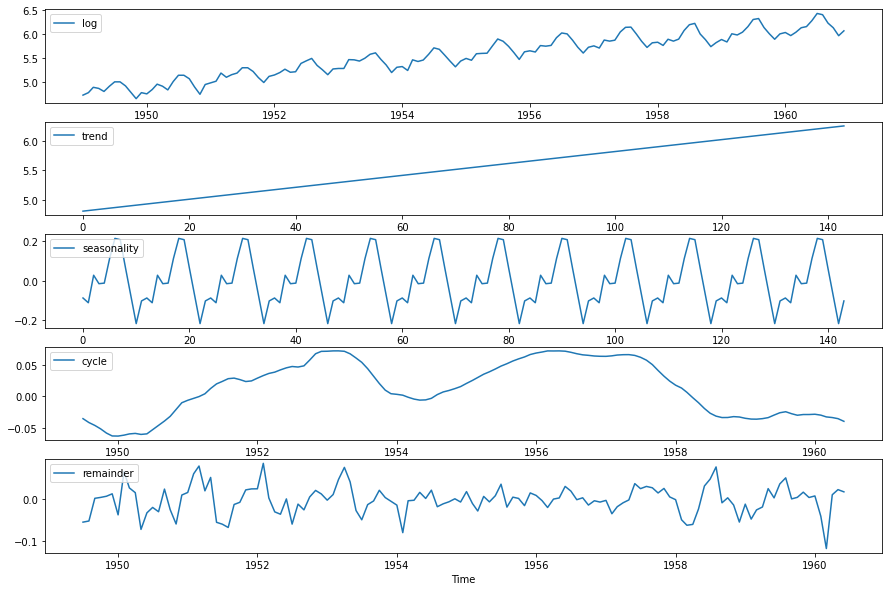

In [6]:
# Plot the seasonally adjusted data:
fig, ax = plt.subplots(5, 1,figsize=(15,10))
ax[0].plot(ts_log)
ax[1].plot(trend_linear)
ax[2].plot(seasonal)
ax[3].plot(cycle)
ax[4].plot(remainder)
ax[0].legend(['log'], loc=2)
ax[1].legend(['trend'], loc=2)
ax[2].legend(['seasonality'], loc=2)
ax[3].legend(['cycle'], loc=2)
ax[4].legend(['remainder'], loc=2)

plt.xlabel('Time')
plt.show()

## 4. In Section 2 (Step 4), how to make forecast for the trend if we use moving average in Step 3.

If we want to use moving average to model the final trend and make forecast, we simply take the average of the last $k$ values of the seasonally adjusted data as the forecast for the trend in the next time step.

$$
\widehat{T}_{t+1|t} = \frac{T_t+T_{t-1}+...+T_{t-k}}{k}
$$

It is a good choice to choose $k=M=12$ in this example

In [7]:
# Forecast the trend component in Jan 1961 by simply getting the average of the last M observed values
Trend_forecast = seasonally_adjusted[-12:].mean()

# Forecast the seasonal component in Jan 1961
Seasonal_forecast = seasonal_idx_normalized[0]

# Get the sum of the trend and seasonal forecasts
Y_forecast = Trend_forecast + Seasonal_forecast

# Convert the forecast value to the original scale
Y_forecast_org = np.exp(Y_forecast)
Y_forecast_org

431.0881039072244

## 5. Using the fitted model in section 3.3, produce the forecast value at $\widehat{Y}_{T+1|T}$. Which model make more accurate forecast for the number of air passengers at $T+1$, the model in section 2 or 3?

We first repeat the variable engineering steps in Section 3 of the tutorial guide to create input variables for the multiple linear regression model

In [8]:
# we start from January
seasons = []
for i in range(y.size):
    if i % 12 == 0:
        seasons = np.append(seasons, 'Jan')
    if i % 12 == 1:
        seasons = np.append(seasons, 'Feb')
    if i % 12 == 2:
        seasons = np.append(seasons, 'Mar')
    if i % 12 == 3:
        seasons = np.append(seasons, 'Apr')
    if i % 12 == 4:
        seasons = np.append(seasons, 'May')
    if i % 12 == 5:
        seasons = np.append(seasons, 'Jun')
    if i % 12 == 6:
        seasons = np.append(seasons, 'Jul')
    if i % 12 == 7:
        seasons = np.append(seasons, 'Aug')
    if i % 12 == 8:
        seasons = np.append(seasons, 'Sep')
    if i % 12 == 9:
        seasons = np.append(seasons, 'Oct')
    if i % 12 == 10:
        seasons = np.append(seasons, 'Nov')
    if i % 12 == 11:
        seasons = np.append(seasons, 'Dec')
        
dummies = pd.get_dummies(seasons, drop_first=True)
dummies.head()

,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0


In [9]:
X = np.linspace(1, len(ts_log), len(ts_log)) # Create time indexes for input variable t
y = ts_log # Values of the output variable Y_t

# dummies is a pandas DataFrame, we shall take values out by getting the attribute values of DataFrame objects
dummies_val = dummies.values

# Now we concatenate these dummy features (columns) to the time column to contruct the training (input) data
Xnew = np.hstack((X.reshape(len(X),1),dummies_val))

We then fit a multiple linear regression model on the training data

In [10]:
# Create linear regression object (model)
mlr = LinearRegression()

# Train the model using the training sets
mlr.fit(Xnew, y)

LinearRegression()

Given the fitted model, let's make the forecast value for (log) number of air passenger at time $T+1$. 

In [11]:
# First, we need to prepare the input for the model at T+1
T_t_plus_1 = np.array([len(ts)+1])   
dummy_t_plus_1 = dummies_val[0,:]    # Dummy code for Jan
X_t_plus_1 = np.concatenate((T_t_plus_1,dummy_t_plus_1))

# Make prediction (log scale)
Y_t_plus_1 = mlr.predict(X_t_plus_1.reshape(1,len(X_t_plus_1)))

# Forecast number of airpassenger on original scale
print('Forecast number of air passenger at T+1: {}'.format(np.exp(Y_t_plus_1[0])))

Forecast number of air passenger at T+1: 486.26661074908867


We need to observe the number of air passengers at time $T+1$ to compare the predictive performance of two models.